---
# Code tutorial for "Phase transitions in optimal transportation networks"
---

In [1]:
#import model 
from init import *

---
### Graph object
---

In [ ]:
#create the local layer with a triangular lattice object with radius R=L/4 
R=25
lattice=Lattice(4*R)

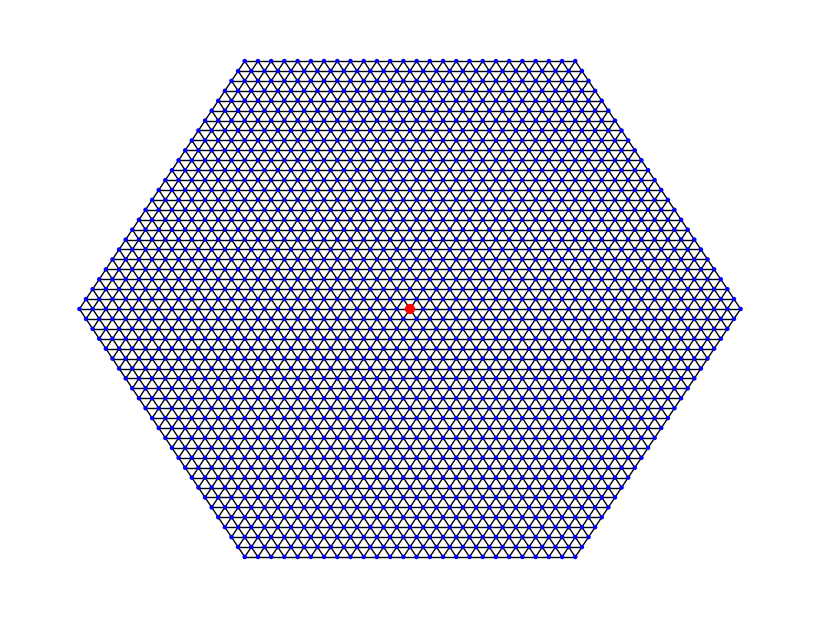

In [21]:
#visualize lattice
#create networkx object for visualization
g=nx.Graph()
g.add_edges_from([(i,j) for i in lattice.bonds for j in lattice.bonds[i]])
nc,ns=['blue' for i in lattice.sites],[5 for i in lattice.sites]
nc[0],ns[0]='red',40
plt.figure(figsize=(8,6))
nx.draw(g,node_color=nc,pos={i:lattice.sites[i] for i in g.nodes()},node_size=ns,edge_color='k',width=1)

In [34]:
#build global layer with switching cost and eta equal to 0.1 and find the greedy solution with 24 edges
graph=Network(lattice,0.1,0.1,0)
greedy_optimization(graph,24)

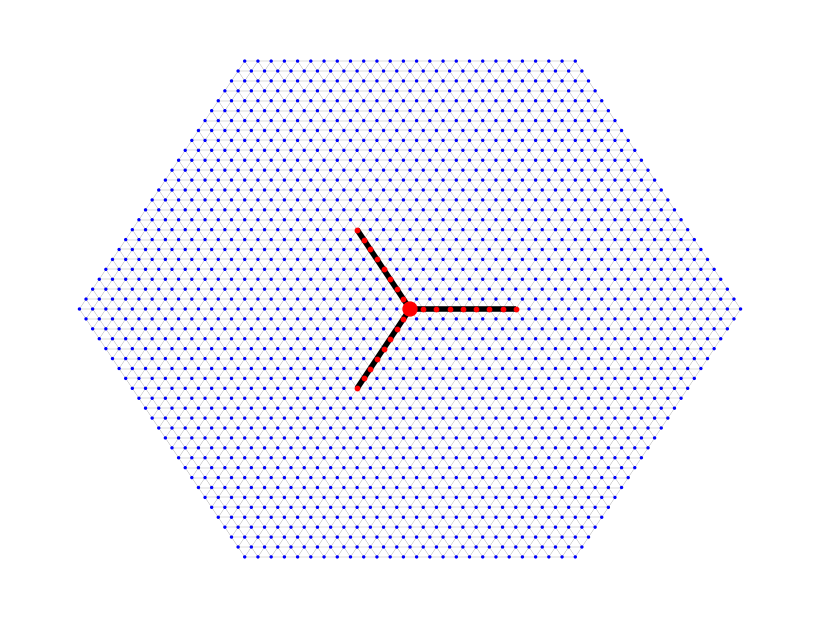

In [37]:
#visualize the solution
g=nx.Graph()
g.add_edges_from([(i,j) for i in lattice.bonds for j in lattice.bonds[i]])
nc,ns=['blue' for i in lattice.sites],[2 for i in lattice.sites]
nc[0],ns[0]='red',100
global_g=get_global_nx(graph,lattice)
plt.figure(figsize=(8,6))

nx.draw(g,node_color=nc,pos={i:lattice.sites[i] for i in g.nodes()},node_size=ns,edge_color='k',width=0.1,alpha=1)
nx.draw(global_g,node_color='red',pos={i:lattice.sites[i%graph.N] for i in global_g.nodes()},node_size=10,edge_color='k',width=4)

---
### Multi-greedy approach
---

In [41]:
# Step 1: create multiple copies of the graph with different switching costs to obtain greedy solutions 
graph=Network(lattice,0.1,0.1,0)
gs=[copy.deepcopy(graph) for _ in range(10)]
cs=np.linspace(0.0001,0.45-0.001,10)

for i in range(10):
    G=gs[i]
    change_c(G,cs[i])
    greedy_optimization(G,12)

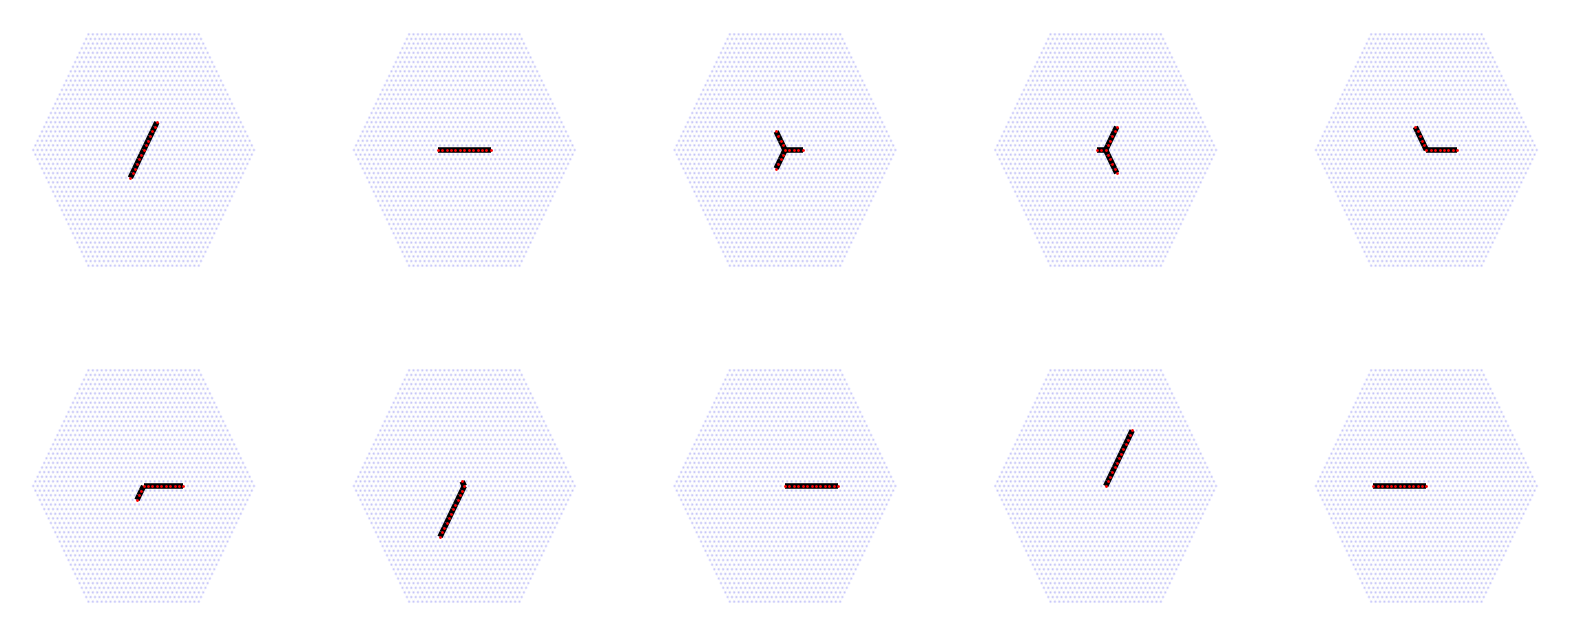

In [45]:
#visualize solutions
fig=plt.figure(figsize=(20,8))
for i in range(10):
    ax=fig.add_subplot(2,5,i+1)
    global_g=get_global_nx(gs[i],lattice)
    nx.draw(g,node_color=nc,pos={i:lattice.sites[i] for i in g.nodes()},node_size=1,edge_color='k',width=0.1,alpha=0.1)
    nx.draw(global_g,node_color='red',pos={i:lattice.sites[i%graph.N] for i in global_g.nodes()},node_size=1,edge_color='k',width=4)

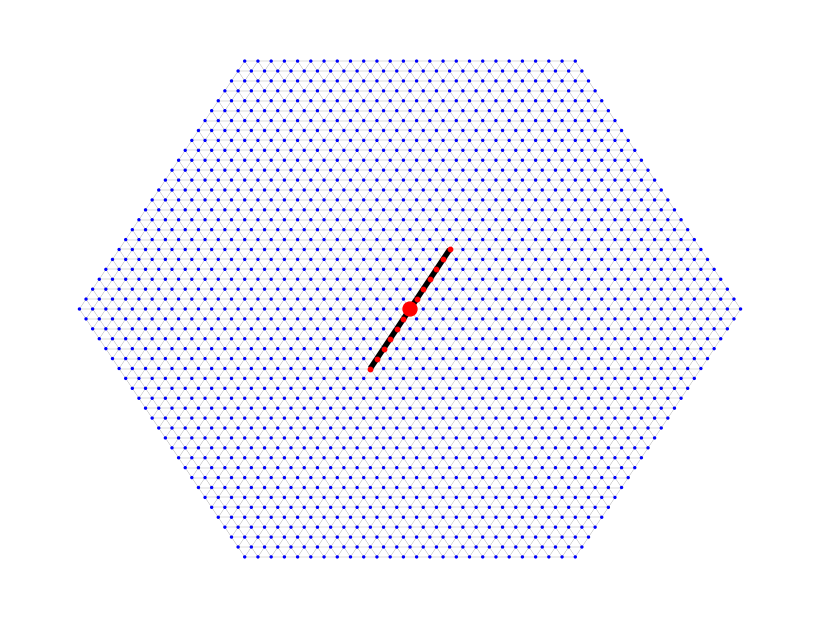

In [48]:
# Step 2: Compute the mean distance to the center for all the solutions for the desired switching cost, say 0.7
solution=gs[greedy_multi_wdata(gs,12,0.7)[-1]]
#visualize the solution
g=nx.Graph()
g.add_edges_from([(i,j) for i in lattice.bonds for j in lattice.bonds[i]])
nc,ns=['blue' for i in lattice.sites],[2 for i in lattice.sites]
nc[0],ns[0]='red',100
global_g=get_global_nx(solution,lattice)
plt.figure(figsize=(8,6))

nx.draw(g,node_color=nc,pos={i:lattice.sites[i] for i in g.nodes()},node_size=ns,edge_color='k',width=0.1,alpha=1)
nx.draw(global_g,node_color='red',pos={i:lattice.sites[i%graph.N] for i in global_g.nodes()},node_size=10,edge_color='k',width=4)

---
### Simulated annealing
---

Text(0, 0.5, 'Average Time to Centre')

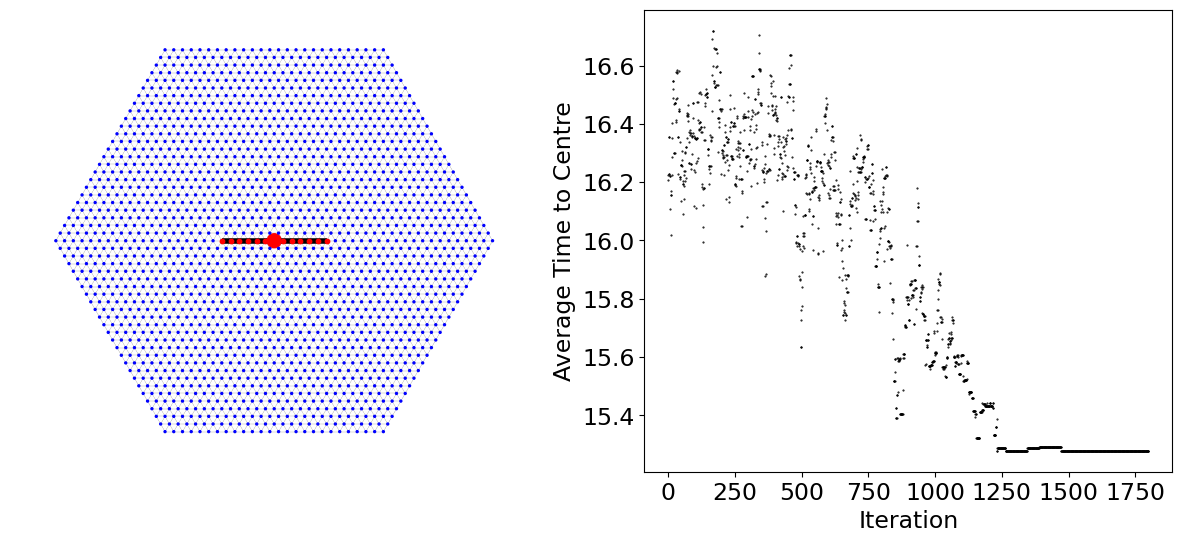

In [54]:
#to verify the optimality of the optimization approach we turn to the slower and more efficient simulated annealing 
#here we try to obtain the solution seen above for c=0.7 using simulated annealing
graph,spls=SA_sol(c=0.7,L=12,eta=0.1,initialTemp=10, finalTemp=1e-3,iterationPerTemp=10, alpha=0.95)
#visualize optimization and solution
global_g=get_global_nx(graph,lattice)
fig=plt.figure(figsize=(15,6))
ax1=fig.add_subplot(1,2,1)
nx.draw(g,node_color=nc,pos={i:lattice.sites[i] for i in g.nodes()},node_size=ns,edge_color='k',width=0.1,alpha=1)
nx.draw(global_g,node_color='red',pos={i:lattice.sites[i%graph.N] for i in global_g.nodes()},node_size=10,edge_color='k',width=4)
ax2=fig.add_subplot(1,2,2)

plt.plot(spls,'.k',markersize=1)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.xlabel('Iteration',fontsize=17)
plt.ylabel('Average Time to Centre',fontsize=17)

---
### Population density
---

(-27.5, 27.5, -23.81569860407206, 23.81569860407206)

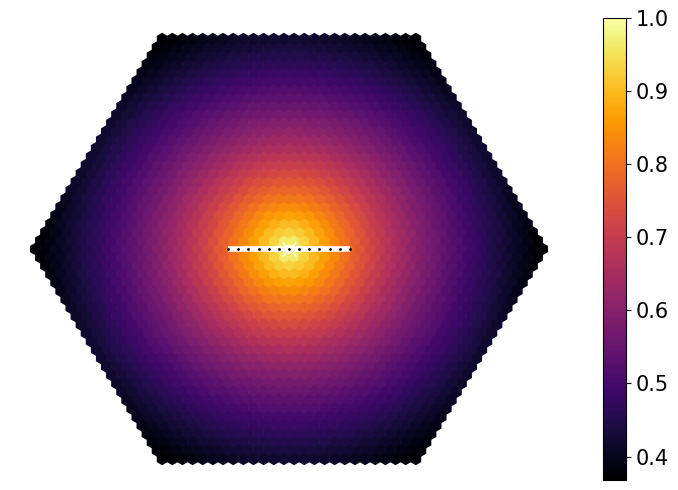

In [76]:
# We incorporate population densities in our model by adding weight to the nodes (details in the supplementary material for the paper)
# Here, we consider the case where the population densities are given by an exponentially decaying distribution P(d)=P(O)*e^{-d/R}
graph_population=Network(lattice,0.1,0.1,1/25)
fig=plt.figure(figsize=(9,6))
plt.plot([0], [0],'xw',markersize=10)
X,Y,c=[lattice.sites[i-graph.N][0] for i in graph.weights.keys()],[lattice.sites[i-graph.N][1] for i in graph.weights.keys()],list(graph_population.weights.values())
plt.scatter(X,Y,s=80,c=c,cmap='inferno',marker='h',alpha=1,edgecolors='None')
nx.draw(global_g,node_color='k',pos={i:lattice.sites[i%graph.N] for i in global_g.nodes()},node_size=1,edge_color='w',width=4)
cb=plt.colorbar()
cb.ax.tick_params(labelsize=15)
plt.axis('off')

---
### Real population data: Atlanta
---

In [79]:
# We can study real spatial distribution by appropriately assigning mapping the city's center, area, and population distribution. For more details, refer to the supplementary material for the paper
# load 2021 Georgia shapefile and census tract-level population data using geopandas
s='Data/acs2021_5yr_B01003_14000US13121011633 2/acs2021_5yr_B01003_14000US13121011633.shp'
population=gpd.read_file(s,geometry='geometry')
population=population.drop(0)
population_georgia = population.to_crs("EPSG:2239")
geometry = Point(-84.3916891,33.7538604)
gdf = gpd.GeoDataFrame(geometry=[geometry])
# use the appropriate coordinate reference system for Atlanta
gdf.crs = 'EPSG:4326'
gdf = gdf.to_crs('EPSG:2239')
#choose center
center=(gdf.geometry.x[0],gdf.geometry.y[0])

In [80]:
#calculate census tract-level density
pops=[int(i) for i in list(population_georgia['B01003001'])]
areas=[i.area*0.00000009290304 for i in list(population_georgia['geometry'])]
densities=[pops[i]/areas[i] for i in range(len(pops))]
population_georgia['density']=densities

In [81]:
# create appropriate network object from population data with boundary of 25 km
hc=Lattice(100)
r=25000/0.3048
R=25
spacing=r/R
#boundary information
boundary = copy.deepcopy(population_georgia)
boundary = boundary.reset_index()
shapes=list(boundary['geometry'])
for k in hc.sites:
    i=hc.sites[k]
    hc.sites[k]=[spacing*i[0]+center[0],spacing*i[1]+center[1]]
    
graph=Network(hc,0.01,1/2,0)
population_density={node:0 for node in graph.edges}
for node in graph.edges:
    if graph.layer[node]=='local':
        p=Point([hc.sites[node]])
        for i in range(len(shapes)):
            if contains(shapes[i],p):
                density=densities[i]
                population_density[node]=float(density)
                break
graph.weights={i+graph.N:population_density[i] for i in graph.edges if graph.layer[i]=='local'}

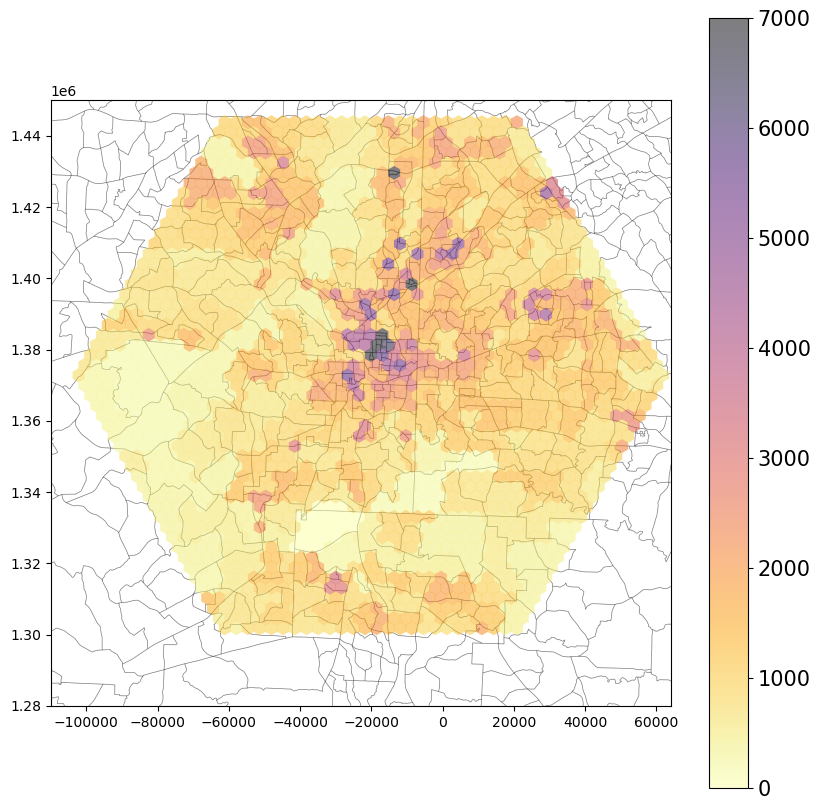

In [87]:
#visualize
#plot
gnx=get_global_nx(graph,hc)
fig=plt.figure(figsize=(10,10))
ax2=fig.add_subplot(111)
population_georgia.plot(ax=ax2,color='white',alpha=0.3, linewidth=0.5, edgecolor='black')
X,Y,c=[hc.sites[i-graph.N][0] for i in graph.weights.keys()],[hc.sites[i-graph.N][1] for i in graph.weights.keys()],list(graph.weights.values())
plt.scatter(X,Y,s=100,c=c,cmap='inferno_r',marker='h',alpha=0.5,edgecolors='None',vmax=7000)
plt.xlim(-0.11e6,0.064e6)
plt.ylim(1.28e6,1.45e6)
cb=plt.colorbar()
cb.ax.tick_params(labelsize=15)